In [45]:
import healpy as hp
import lunarsky
import matplotlib.pyplot as plt
import pyradiosky
import pyuvdata
import pyuvsim
import numpy as np
import uvtools

fatal: No names found, cannot describe anything.


## Load 21cm models

In [2]:
# def z_to_nu(z):
#     nu_0 = 1420405751.768  # Hz
#     return nu_0 / (z+1)

# redshifts = np.loadtxt('z_EIGSEP.txt')
# freqs_models = z_to_nu(redshifts) / 1e9  # GHz
# models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

# freqs_models = freqs_models[::-1]
# models = models[:, ::-1]

In [3]:
# # load standard models
# ares_models = np.load('models_21cm.npz')
# ares_T21 = ares_models['models'] / 1e3  # mK to K
# ares_freqs = ares_models['freqs']

## Import Beams

In [4]:
uvb_path = "../luseesky/uvbeams/003/"
fname = "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.uvbeam"

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(uvb_path + fname)

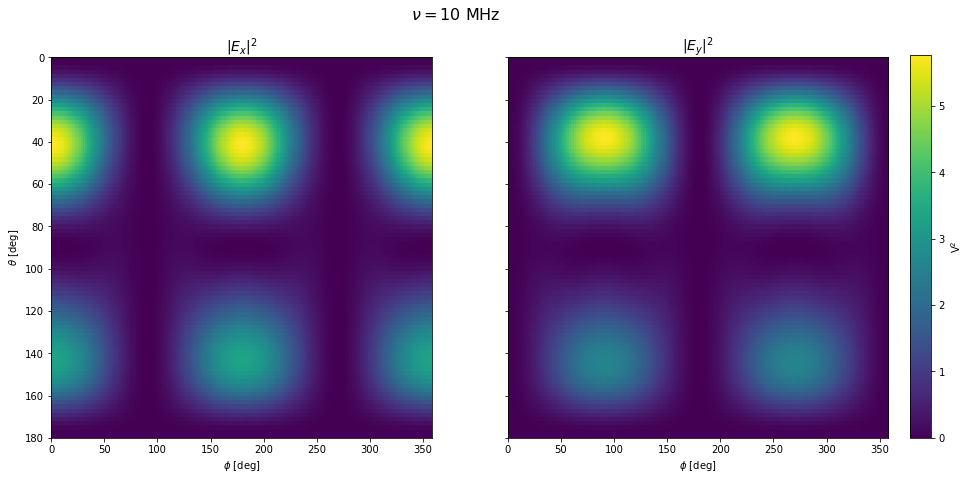

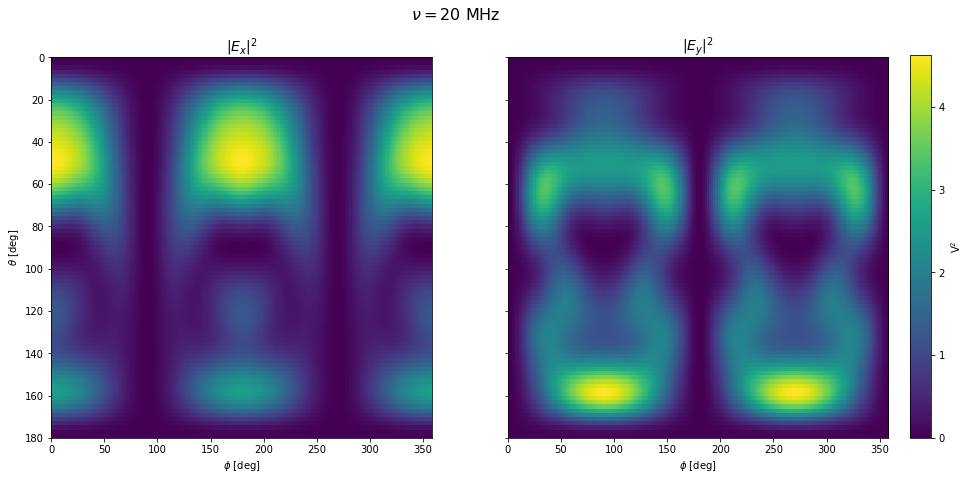

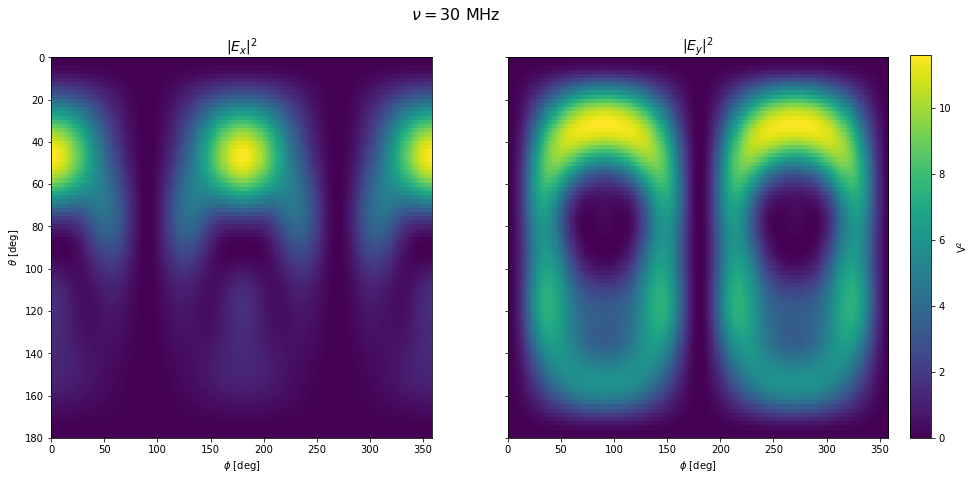

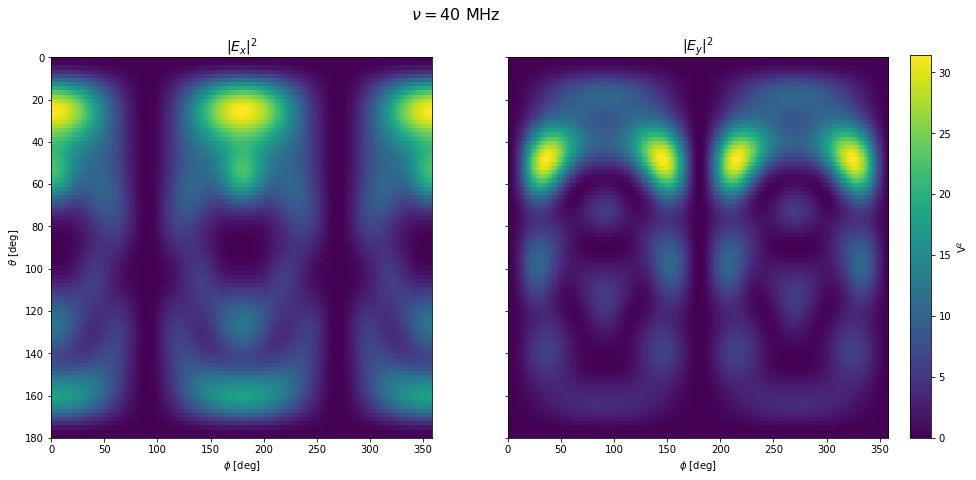

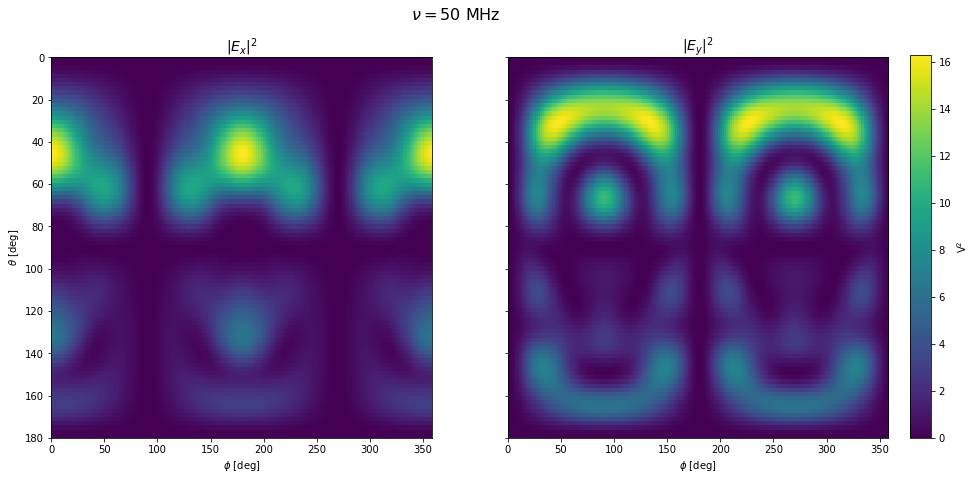

In [5]:
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
extent = [left, right, bottom, top]
components = ["$|E_x|^2$", "$|E_y|^2$"]

for freq in [10, 20, 30, 40, 50]:
    find = np.argmin(np.abs(uvb.freq_array[0] - freq*1e6))
    fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        im = ax.imshow(np.abs(uvb.data_array[i, 0, i, find])**2, interpolation="none", aspect="auto", extent=extent)
        ax.set_xlabel("$\\phi$ [deg]")
        if i == 0:
            ax.set_ylabel("$\\theta$ [deg]")
        ax.set_title(components[i], fontsize=14)
    cax=fig.add_axes([0.92, 0.125, .02, .76])
    plt.colorbar(im, cax, label="$\\rm{V}^2$")
    plt.suptitle('$\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, find]/1e6), fontsize=16)
    plt.show()

## Load skymodel

In [6]:
# uvsim can read source catalogs, how does that link to skymaps?
# sol might be here: https://github.com/RadioAstronomySoftwareGroup/pyradiosky/blob/main/pyradiosky/skymodel.py
# https://arxiv.org/pdf/2104.03170.pdf (ULSA)

# in the meantime we use some sources at the moon zenith

In [7]:
loc = lunarsky.MoonLocation(lon=0.6875, lat=24.433, height=0)
skymodel = pyuvsim.simsetup.create_mock_catalog(2459630., arrangement="zenith", array_location=loc, Nsrcs=10,
                                                save=False)

In [8]:
skymodel[0].write_skyh5("../sim_files/mock_zenith.skyh5", clobber=True)

File exists; clobbering.


## Run UVSim

In [9]:
# this does the same as pyuvsim/scripts/run_param_pyuvsim.py
# optional: pyuvsim profiler?
uvdata = pyuvsim.uvsim.run_uvsim("../sim_files/obsparam.yaml", return_uv=True, quiet=False)

All polarized beams have x_orientation set to None. This will make it hard to interpret the polarizations of the simulated visibilities.


UVData initialization took 0.007 min
Skymodel setup took 0.000 min
Nbls: 1
Ntimes: 256
Nfreqs: 50
Nsrcs: 10
Tasks:  12800.0
1.00% completed. 0:00:00.475986  elapsed. 0:00:47.122614 remaining. 

2.00% completed. 0:00:00.724202  elapsed. 0:00:35.485882 remaining. 

3.00% completed. 0:00:00.892045  elapsed. 0:00:28.842804 remaining. 

4.00% completed. 0:00:01.061974  elapsed. 0:00:25.487371 remaining. 

5.00% completed. 0:00:01.228538  elapsed. 0:00:23.342218 remaining. 

6.00% completed. 0:00:01.399865  elapsed. 0:00:21.931217 remaining. 

7.00% completed. 0:00:01.568797  elapsed. 0:00:20.842590 remaining. 

8.00% completed. 0:00:01.737790  elapsed. 0:00:19.984586 remaining. 

9.00% completed. 0:00:01.908147  elapsed. 0:00:19.293487 remaining. 

10.00% completed. 0:00:02.073954  elapsed. 0:00:18.665589 remaining. 

11.00% completed. 0:00:02.242450  elapsed. 0:00:18.143461 remaining. 

12.00% completed. 0:00:02.408628  elapsed. 0:00:17.663268 remaining. 

13.00% completed. 0:00:02.578815 

In [64]:
## output is real ...
print(np.max(np.abs(uvdata.data_array.imag)))
print("Discarding imaginary part...")
uvdata.data_array = uvdata.data_array.real

3.469446951953614e-17
Discarding imaginary part...


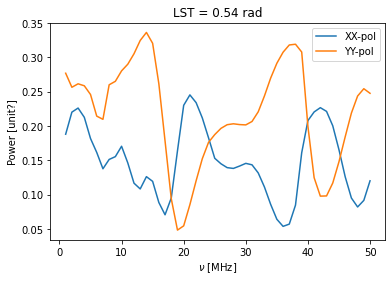

In [69]:
plt.figure()
plt.plot(uvdata.freq_array[0]/1e6, uvdata.data_array[0, 0, :, 0], label="XX-pol")
plt.plot(uvdata.freq_array[0]/1e6, uvdata.data_array[0, 0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Power [unit?]")
plt.title("LST = {:.2f} rad".format(uvdata.lst_array[0]))
plt.show()

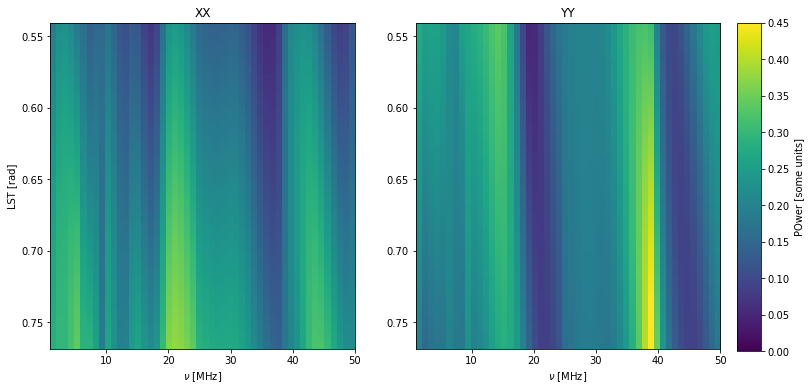

In [98]:
extent = [uvdata.freq_array[0].min()/1e6, uvdata.freq_array[0].max()/1e6, uvdata.lst_array.max(), uvdata.lst_array.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 0], mode='abs', extent=extent)
im.set_clim(0, 0.45)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(uvdata.data_array[:, 0, :, 1], mode='abs', extent=extent)
im.set_clim(0, 0.45)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="POwer [some units]")

## Compute eigenmodes

In [123]:
pols = ["XX", "YY"]

idata = uvdata.data_array[:, 0, :, :2]  # uncalibrated, nspws=0, no crosspols
d = idata - np.mean(idata, axis=0)  # subtract mean

V_full = np.empty((uvdata.freq_array[0].size, uvdata.freq_array[0].size, 2)) # eigenvector change of basis
for i, _ in enumerate(pols):  # compute for both XX and YY
    C = np.dot(d[:, :, i].T, d[:, :, i])  # covariance matrix
    U, S, V = np.linalg.svd(C)
    V_full[:, :, i] = V 

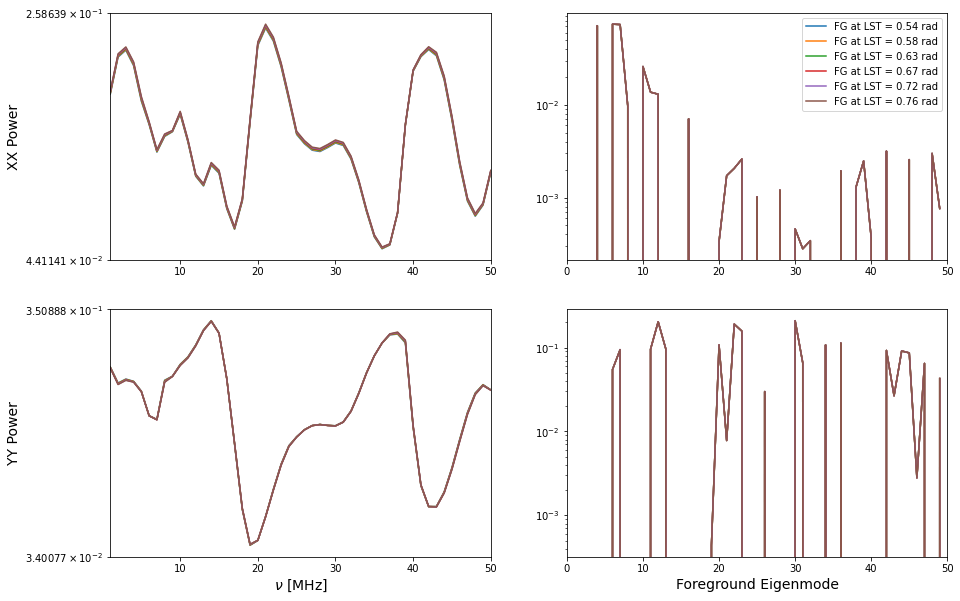

In [149]:
fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

for i, lst in enumerate(uvdata.lst_array[::50]):
    axs[0, 0].plot(uvdata.freq_array[0]/1e6, np.abs(idata[i, :, 0]), label="FG at LST = {:.2f} rad".format(lst))
    axs[0, 1].plot(V_full[:, :, 0] @ idata[i, :, 0], label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 0].plot(uvdata.freq_array[0]/1e6, np.abs(idata[i, :, 1]), label="FG at LST = {:.2f} rad".format(lst))
    axs[1, 1].plot(V_full[:, :, 0] @ idata[0, :, 1], label="FG at LST = {:.2f} rad".format(lst))

plt.setp(axs[:, 0], yscale="symlog", xlim=(uvdata.freq_array[0].min()/1e6, uvdata.freq_array[0].max()/1e6))
plt.setp(axs[:, 1], yscale="log", xlim=(0, len(V_full)))
axs[1, 0].set_xlabel("$\\nu$ [MHz]", fontsize=14)
axs[1, 1].set_xlabel("Foreground Eigenmode", fontsize=14)
for i, pol in enumerate(pols):
    axs[i, 0].set_ylabel(f"{pol} Power", fontsize=14)
axs[0, 1].legend()

plt.show()